In [1]:

import numpy as np
from matplotlib import pyplot as plt
from IPython import display

from scipy.spatial.distance import cdist
import cv2
from scipy.stats import norm
import time

from IPython import display

np.random.seed(0)

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
class grid_env():
    
    def __init__(self):
        self.N = 20 # size of the grid map

        
        x = np.arange(self.N) # create x coord array
        y = np.arange(self.N) # create y coord array

        self.xx,self.yy = np.meshgrid(x,y) # create matrices of x and y coords, as separate matrices

        self.xl = np.random.randint(self.N) # goal location
        self.yl = np.random.randint(self.N)

        self.fv = lambda x,y : np.exp(-1*((x-self.xl)**2+(y-self.yl)**2)) # e^(-dist^2). gaussian proximity reward function
        
        self.f = self.fv(self.xx,self.yy) # reward matrix
        
        self.state = np.random.randint(self.N,size=2) # random initial location
        
        self.action_space = np.array([[0,1],[0,-1],[-1,0],[1,0]]) # up down left right 
        
    # apply action and update the state
    def mm(self,X,u,dt=0.1):
        x = X[0] + u[0]
        y = X[1] + u[1]

        return np.array([x,y])
    
    # step one action
    def step(self,idx):
        u = self.action_space[idx,:]
        new_state = self.mm(self.state,u)
        new_state = np.clip(new_state,0,self.N-1)
        self.state = np.copy(new_state)
        
        # if the gaussian proximity lookup table returns higher than 0.1
        if self.f[new_state[1],new_state[0]] > 0.1:
            feature = 2.0 
        else:
            feature = 0.0 
        
        # return new state, gaussian proximity reward, feature (unused)
        return self.state,self.f[new_state[1],new_state[0]],feature
    
    def reset(self):
        self.state = np.random.randint(self.N,size=2)
        if self.f[self.state[1],self.state[0]] > 0.1:
            feature = 2.0
        else:
            feature = 0.0
        return np.copy(self.state),feature

In [9]:
# takes in the env, Q table, episode length
# plays one episode
# plots the reward and q value for every step. 
def test_value(env,Q,steps=50,disp=True):
    state,feature = env.reset()
    xm = [] # state
    rsum = 0 # total reward
    for j in range(steps):
        a = np.argmax(Q[env.N*state[1]+state[0],:]) # select the best action

        state,reward,feature = env.step(a)
    
        xm.append(np.copy(state))
        rsum = rsum+reward
        if disp:
            plt.clf()
            plt.subplot(1,2,1)
            plt.imshow(env.f,origin='lower',extent=[0,env.N+20,0,env.N])
            plt.title('Actual reward')
            plt.plot(np.vstack(xm)[:,0],np.vstack(xm)[:,1])

            plt.subplot(1,2,2)
            plt.imshow(np.max(Q,axis=1).reshape(env.N,env.N),origin='lower',extent=[0,env.N,0,env.N])
            plt.title('Q estimate')
            plt.plot(np.vstack(xm)[:,0],np.vstack(xm)[:,1],'-o')
            plt.title(j)

            display.clear_output(wait=True)
            display.display(plt.gcf())
    return rsum, xm

In [10]:
def value_iteration(env,init=None,iters=10000,alpha=0.9,gamma=0.9,eps_greedy_init=0.5,eps_anneal=True,plot_freq=1,disp=True):
    
    if init is None:
        Q = np.ones((env.N*env.N,env.action_space.shape[0])) # initialise Q table
    else:
        Q = init
    reward = 0
    if disp:
        plt.figure(figsize=(15,5))
    xm = []
    rewards = []
    for j in range(iters):
        state = np.copy(env.state)
        
        # Epsilon-greedy
        if eps_anneal:
            eps_greedy = eps_greedy_init*np.exp(1-iters/(j+1))
        else:
            eps_greedy = eps_greedy_init
            
        if np.random.rand() < eps_greedy:
            a = np.argmax(Q[env.N*state[1]+state[0],:])
        else:
            a = np.random.randint(env.action_space.shape[0])

        new_state, new_reward,feature = env.step(a)
        xm.append(np.copy(new_state))

        new_a = np.argmax(Q[env.N*new_state[1]+new_state[0],:])
        Qmax = Q[env.N*new_state[1]+new_state[0],new_a]
        Q[env.N*state[1]+state[0],a] = (1-alpha)*Q[env.N*state[1]+state[0],a] + alpha*(reward + gamma*Qmax)
        reward = new_reward
        
        rewards.append(reward)
        
        if (j %plot_freq == 0) and (disp):
            plt.clf()
            plt.subplot(2,3,1)
            plt.imshow(env.f,origin='lower',extent=[0,env.N,0,env.N])
#             plt.plot(np.vstack(xm)[:,0],np.vstack(xm)[:,1])
            plt.title('True reward')
            plt.subplot(2,3,2)
            plt.imshow(np.max(Q,axis=1).reshape(env.N,env.N),origin='lower',extent=[0,env.N,0,env.N])
#             plt.plot(np.vstack(xm)[:,0],np.vstack(xm)[:,1])
            plt.title('Q value')
            plt.subplot(2,3,3)
            plt.imshow(np.argmax(Q,axis=1).reshape(env.N,env.N),origin='lower',extent=[0,env.N,0,env.N])
#             plt.plot(np.vstack(xm)[:,0],np.vstack(xm)[:,1])
            plt.title('Best action')
            plt.subplot(2,1,2)
            plt.plot(rewards,'o',alpha=0.01)
            plt.ylabel('Reward')
            plt.xlabel('Env interaction')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print (eps_greedy)
    return Q

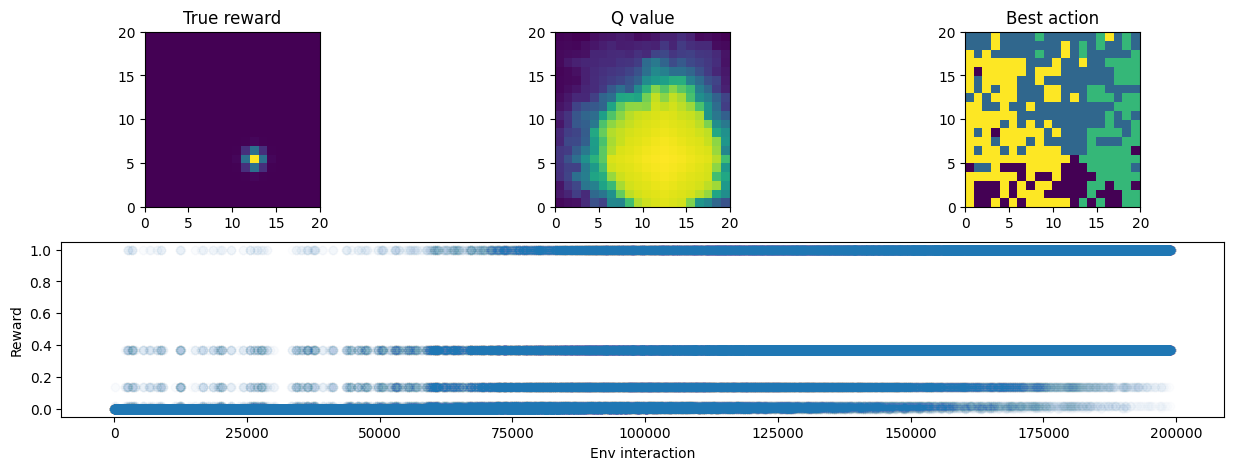

0.985042579200607


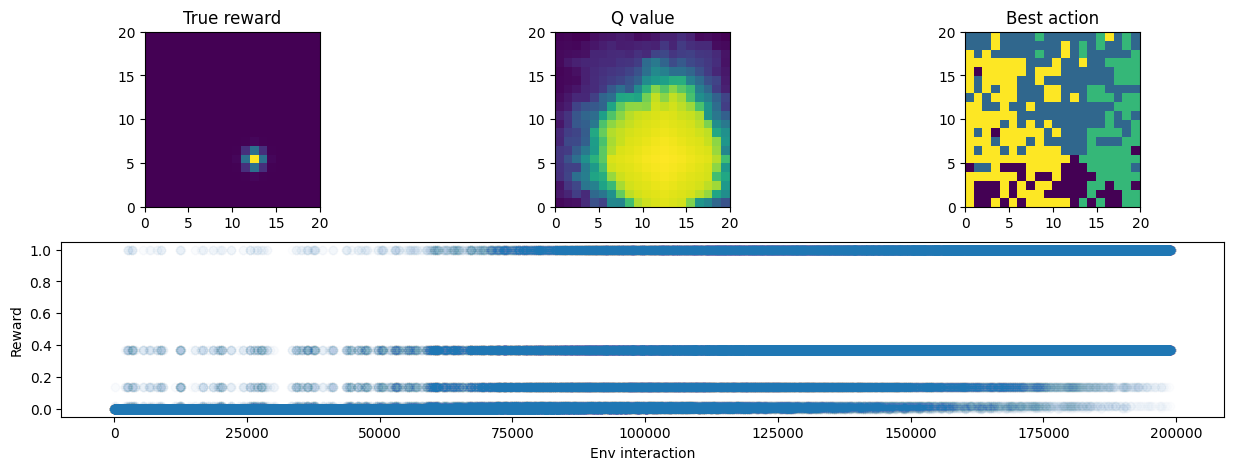

In [11]:
#Create new env with estimated reward and train agent
new_env = grid_env()
newQ = value_iteration(new_env,iters=200000,alpha=0.5,gamma=0.99,eps_greedy_init=0.99,eps_anneal=True,disp=True,plot_freq=1000)


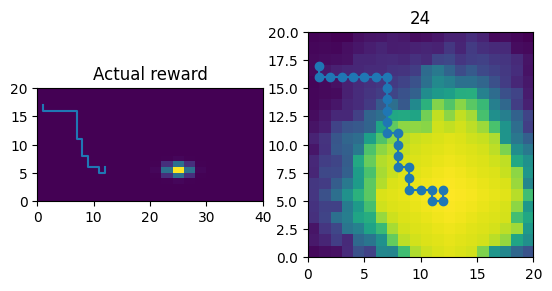

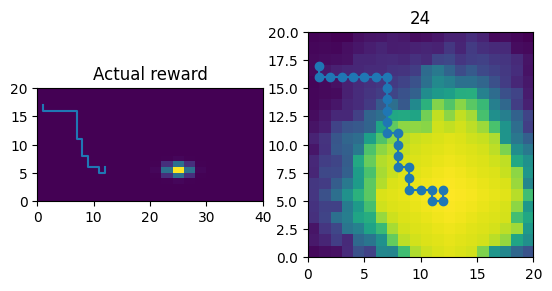

In [12]:
# Test agent on original world
rsum,traj = test_value(new_env,newQ,steps=25,disp=True)